We study Table 13.2 on p 240 of Lange and Chapter 13 question 11 (on page 240) and Chapter 14, Example 14.10.1 on p246.

The table contains counts of the number of days a given number of deaths occurred. 

In [1]:
import numpy as np
freq = np.array([162,267,271,185,111,61,27,8,3,1])

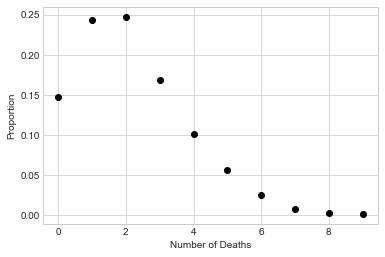

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## proportion of different number of deaths
plt.plot(np.arange(freq.size), freq/np.sum(freq), 'o', color='black')
plt.xlabel("Number of Deaths")
plt.ylabel("Proportion");

## Problem 1

Confirm Lange's claim in question 11 that "A Poisson distribution gives a poor fit to these data . . ." by computing the MLE of the Poisson parameter $\lambda$ (this can be done by hand using calculus) and plotting the resulting probability mass function over the observed data. They should be a bit discrepant (thus justifying the claim).

The Poisson probability mass function is
$$ f(x|\lambda) = \frac{e^{-\lambda}\lambda^x}{x!}$$

The MLE maximizes the log likelihood. The log likelihood for the sample is
\begin{align*}
\log f(\vec{x}) &= \log \prod_{i=1}^n f(x_i|\lambda)\\
&= \sum_{i=1}^n \log f(x_i|\lambda)\\
&= \sum_{i=1}^n (-\lambda + x_i\log \lambda - \log x!)\\
&= -n\lambda + \sum_{i=1}^n(x_i) \log \lambda - \sum_{i=1}^n \log x!
\end{align*}
Differentienting, setting equal to $0$, and solving for $\lambda$, we obtain
$$ \widehat{\lambda} = \bar{X} = \frac{1}{n}\sum_{i=1}^n X_i $$
In other words, the MLE is the sample mean.

In [3]:
import math as mt

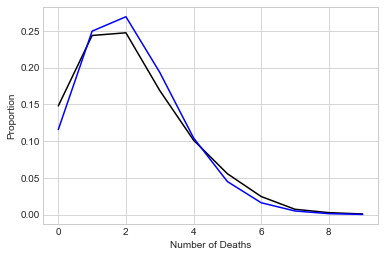

In [4]:
lamda = np.sum(freq*np.arange(freq.size)) / np.sum(freq)
pmf = []
for i in range(freq.size):
    pmf.append(np.exp(-lamda) * (lamda**i) / mt.factorial(i))

plt.plot(np.arange(freq.size), freq/np.sum(freq), color='black')
plt.plot(np.arange(freq.size), pmf, color='blue')
plt.xlabel("Number of Deaths")
plt.ylabel("Proportion");

## Problem 2

Fit the $\alpha$, $\mu_1$ and $\mu_2$ parameters for the mixture of two Poissons model proposed in Question 11. You must write your own fitting code (cannot use `scipy optimize` or R `optim`). You can write any sort of optimizer you like such as gradient ascent, Newton's method (or any of its varients), or an EM approach. Discuss how you select starting parameters and monitor convergence. You can confirm your results by also using Python or R built in optimizers.

The answer to problem 1 used standard notation for the data i.e. $x_1$ was the number of deaths on day 1. Now we let $n_i = $ number of days with $i$ deaths. So
$$n_i = \sum_j \mathbb{1}_{X_j=i}$$

The likelihood is
$$f(\vec{n}|\alpha,\mu_1,\mu_2) = \prod_{i=0}^9 \left(\underbrace{\alpha e^{-\mu_1} \frac{\mu_1^i}{i!} + (1-\alpha)e^{-\mu_2}\frac{\mu_2^i}{i!}}_{\equiv g_i}\right)^{n_i}$$

So the log likelihood is
$$ \log \, f = \sum_{i=0}^9 n_i \log(g_i) $$

The gradient is
$$ \frac{\partial log f}{\partial \alpha} = \sum_{i=0}^9 \frac{n_i}{g_i} \frac{\partial g_i}{\partial \alpha}$$
$$ \frac{\partial log f}{\partial \mu_j} = \sum_{i=0}^9 \frac{n_i}{g_i} \frac{\partial g_i}{\partial \mu_j}$$
for $j=1,2$ and where
$$\frac{\partial g_i}{\partial \alpha} = e^{-\mu_1} \frac{\mu_1^i}{i!} - e^{-\mu_2}\frac{\mu_2^i}{i!}$$
$$\frac{\partial g_i}{\partial \mu_1} = -\alpha e^{-\mu_1} \frac{\mu_1^i}{i!} + \alpha e^{-\mu_1} \frac{\mu_1^{i-1}\mathbb{1}_{i > 0}}{(i-1)!}$$
$$\frac{\partial g_i}{\partial \mu_1} = -(1-\alpha) e^{-\mu_2} \frac{\mu_2^i}{i!} + (1-\alpha) e^{-\mu_2} \frac{\mu_2^{i-1}\mathbb{1}_{i > 0}}{(i-1)!}.$$
Note the indicator functions. These are important for the second terms in the $\partial g_i / \partial \mu_j$ which are $0$ for $i=0$ (because we are differentiating a constant).

We now write functions to implement the log likelihood and gradient.

In [5]:
import scipy

def g(alpha,mu1,mu2,N):
    iis = np.arange(N)
    iisf = scipy.special.factorial(iis)
    return alpha*np.exp(-mu1)*np.power(mu1,iis)/iisf + (1-alpha)*np.exp(-mu2)*np.power(mu2,iis)/iisf

## params = alpha, mu1, mu2 1-d array of parameters
## n = 1-d array of counts of the number of deaths
def log_likelihood(params,n):
    return np.sum(n*np.log(g(params[0],params[1],params[2],n.size)))
    

The gradient is a bit more complicated.

In [6]:
def dgda(mu1,mu2,N):
    iis = np.arange(N)
    iisf = scipy.special.factorial(iis)
    return np.exp(-mu1)*np.power(mu1,iis)/iisf - np.exp(-mu2)*np.power(mu2,iis)/iisf

## omits the leading alpha for mu1 and leading (1-alpha) for mu2
def dgdmu(mu,N):
    iis = np.arange(N)
    iisf = scipy.special.factorial(iis)
    temp = np.exp(-mu)*np.power(mu,iis[:(N-1)])/iisf[:(N-1)]
    return -np.exp(-mu)*np.power(mu,iis)/iisf + np.concatenate((np.zeros(1),temp))

## params = alpha, mu1, mu2 1-d array of parameters
## n = 1-d array of counts of the number of deaths
def gradient_log_likelihood(params,n):
    alpha = params[0]
    mu1 = params[1]
    mu2 = params[2]
    N = n.size
    nog = n / g(alpha,mu1,mu2,N)
    c1 = dgda(mu1,mu2,N)
    c2 = alpha*dgdmu(mu1,N)
    c3 = (1-alpha)*dgdmu(mu2,N)
    return np.array((np.sum(nog*c1),np.sum(nog*c2),np.sum(nog*c3)))

We now implement gradient ascent with step halving.

In [7]:
## gradient ascent with step halving
Niter = 1000
param_initial = np.array((0.3,1.0,2.5))
param = np.zeros((Niter+1)*3).reshape(Niter+1,3)
param[0,:] = param_initial
param[0,:]

array([ 0.3,  1. ,  2.5])

In [8]:
for ii in np.arange(Niter):
    grad = gradient_log_likelihood(param[ii,:],freq)
    half = True
    while half:
        param_temp = param[ii,:] + grad
        ## the new likelihood could produce nan because
        ## we take the log of a negative number
        ## if so, step halve
        newlik = log_likelihood(param_temp,freq)
        if np.isnan(newlik) or (newlik < log_likelihood(param[ii,:],freq)):
            grad = grad / 2
        else:
            half = False
    param[ii+1,:] = param_temp

C:\Users\Kanchan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [9]:
## looks correct
param

array([[ 0.3       ,  1.        ,  2.5       ],
       [ 0.22706808,  1.01877166,  2.52908317],
       [ 0.25187606,  1.01496951,  2.52085513],
       ..., 
       [ 0.3598852 ,  1.25609473,  2.6634041 ],
       [ 0.3598852 ,  1.25609473,  2.6634041 ],
       [ 0.3598852 ,  1.25609473,  2.6634041 ]])

## Functionalize Gradient Code

We now turn gradient code into a function so we can easily plot parameter path from several starting points.

In [10]:
## arguments
##        loglike : log likelihood function
##       dloglike : gradient (derivative of log likelihood)
##  param_initial : initial parameter values for algorithm
##              X : data
##          Niter : number of iterations
##
##
##    value
##       param    :  2-D array with rows giving the parameter values at
##                   each iteration
##
##    note: the function loglike and dloglike must have arguments
##          (parameters,data)
##          loglike must return a scalar and dloglike must return a 1-D
##          np array of length p
def gradient_ascent(loglike,dloglike,param_initial,X,Niter):
    p = param_initial.size
    param = np.zeros((Niter+1)*p).reshape(Niter+1,p)
    param[0,:] = param_initial
    for ii in np.arange(Niter):
        grad = dloglike(param[ii,:],X)
        half = True
        while half:
            param_temp = param[ii,:] + grad
            ## the new likelihood could produce nan because
            ## we take the log of a negative number
            ## if so, step halve
            newlik = loglike(param_temp,X)
            if np.isnan(newlik) or (newlik < log_likelihood(param[ii,:],X)):
                grad = grad / 2
            else:
                half = False
        param[ii+1,:] = param_temp
    return param

We call function with 3 different starting values.

In [11]:
## call function
Niter = 1000

param_initial = np.array((0.3,1.0,2.5))
param1 = gradient_ascent(log_likelihood,gradient_log_likelihood,param_initial,freq,Niter)
param1

C:\Users\Kanchan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


array([[ 0.3       ,  1.        ,  2.5       ],
       [ 0.22706808,  1.01877166,  2.52908317],
       [ 0.25187606,  1.01496951,  2.52085513],
       ..., 
       [ 0.3598852 ,  1.25609473,  2.6634041 ],
       [ 0.3598852 ,  1.25609473,  2.6634041 ],
       [ 0.3598852 ,  1.25609473,  2.6634041 ]])

In [12]:
param_initial = np.array((0.5,0.5,4.1))
param2 = gradient_ascent(log_likelihood,gradient_log_likelihood,param_initial,freq,Niter)
param2

C:\Users\Kanchan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


array([[ 0.5       ,  0.5       ,  4.1       ],
       [ 0.24923513,  0.90173495,  3.95861443],
       [ 0.56916043,  0.90473252,  3.86359071],
       ..., 
       [ 0.3598856 ,  1.25609547,  2.66340461],
       [ 0.3598856 ,  1.25609547,  2.66340461],
       [ 0.3598856 ,  1.25609547,  2.66340461]])

In [13]:
param_initial = np.array((0.8,0.1,1.0))
param3 = gradient_ascent(log_likelihood,gradient_log_likelihood,param_initial,freq,Niter)
param3

C:\Users\Kanchan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Kanchan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


array([[ 0.8       ,  0.1       ,  1.        ],
       [-0.07149436,  0.48151832,  1.33857954],
       [-0.22943851,  0.47434128,  1.65158431],
       ..., 
       [ 0.35988535,  1.25609502,  2.6634043 ],
       [ 0.35988535,  1.25609502,  2.6634043 ],
       [ 0.35988535,  1.25609502,  2.6634043 ]])

### Plot Parameter Paths

We plot the $\mu_1$, $\mu_2$ parameter paths. You could also plot these paths for $\alpha$.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

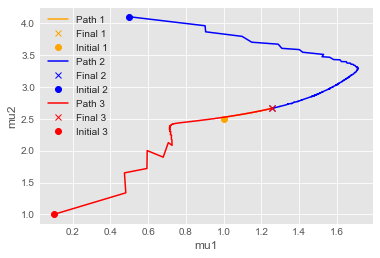

In [15]:
#plt.plot(param1[:,1],param1[:,2])

## sequence 1
plt.plot(param1[:,1],param1[:,2],color='orange',label="Path 1")
plt.plot(param1[Niter,1],param1[Niter,2],'x',color='orange',label="Final 1")
plt.plot(param1[0,1],param1[0,2],'o',color='orange',label="Initial 1")
## sequence 2
plt.plot(param2[:,1],param2[:,2],color='blue',label="Path 2")
plt.plot(param2[Niter,1],param2[Niter,2],'x',color='blue',label="Final 2")
plt.plot(param2[0,1],param2[0,2],'o',color='blue',label="Initial 2")
## sequence 3
plt.plot(param3[:,1],param3[:,2],color='red',label="Path 3")
plt.plot(param3[Niter,1],param3[Niter,2],'x',color='red',label="Final 3")
plt.plot(param3[0,1],param3[0,2],'o',color='red',label="Initial 3")
plt.xlabel("mu1")
plt.ylabel("mu2")
leg = plt.legend(loc='upper left')
plt.show()